# 0 - Importing necessary packages/libraries/APIs

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler as std_scaler, OneHotEncoder as OHE
import pickle
import json
import matplotlib.pyplot as plt
import time
import gc

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)
pd.set_option('display.width', 1000)

# 2 - Defining and training models

## 2.1 - Importing data

In [5]:
# Handling jaguar movement data
class JaguarDataHandler():
    def __init__(self, directory = "./data/jaguar_data/"):
        self.directory = directory
        self.datasets = []
        self.training_Xs = []
        self.training_Ys = []
        
    def load_data(self, IDs = None):
        for id in IDs:
            name = "jag_"+str(id)+".csv"
            chunk = pd.read_csv(self.directory+name, sep = ",", decimal = ".", chunksize = 10000)
            data = pd.concat(chunk, ignore_index = True)
            del chunk
            self.datasets.append(
                data
            )
        return 0
    
    def data2training(self, variables, target_variables, target, step_ID, jaguar_ID = None,
                      del_IDs = True, del_original = False):
        
        if not target in target_variables:
            return -1
        if del_IDs and not step_ID:
            return -1
        
        for data in self.datasets:
            J = data.copy()
            X = J.filter(variables)
            Y = J.filter(target_variables)
            step_id = J[step_ID].unique()
            X_tf = []
            Y_tf = []
            for i in step_id:
                X_tmp = X[(X[step_ID] == i)]
                Y_tmp = Y[(Y[step_ID] == i)]
                Y_tmp = Y_tmp.filter([target])
                
                if del_IDs:
                    X_tmp.drop([jaguar_ID, step_ID], axis = 1, inplace = True)
                
                X_tf.append(X_tmp.to_numpy())
                Y_tf.append(Y_tmp.to_numpy().T)
            X_tf = tf.constant(X_tf)
            Y_tf = tf.constant(Y_tf)
            Y_tf = tf.reshape(Y_tf, [Y_tf.shape[0],Y_tf.shape[2]])
            self.training_Xs.append(X_tf)
            self.training_Ys.append(Y_tf)
        
        if del_original:
            self.datasets = []
            
        return 0
        

In [6]:
# Create data handler
data_handler = JaguarDataHandler()

In [7]:
# Importing Jaguar 12's data
data_handler.load_data(IDs = [12,13,18,22,23,41,52,81,88,91,92,116,117])

0

In [49]:
x0 = data_handler.datasets[0]

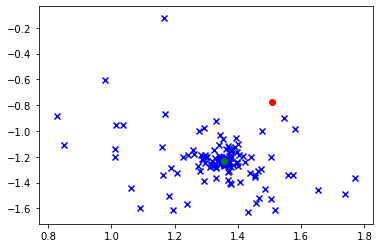

In [53]:
plt.figure()
x01 = x0[x0['step_Num'] == 2].reset_index()
x01.drop('index',axis=1,inplace=True)
plt.scatter(x01['suggested_x'][1:], x01['suggested_y'][1:], marker='x', color='b')
plt.scatter(x01['current_x'][0], x01['current_y'][0], marker='o', color = 'g')
plt.scatter(x01['suggested_x'][0], x01['suggested_y'][0], marker='o', color='r')

In [42]:
np.mean([x01['suggested_x'][1:], x01['suggested_y'][1:]],axis=1)

array([ 1.11263813, -0.38855891])

In [43]:
x01['current_x'][0], x01['current_y'][0]

(1.1134696605508, -0.3940127154444753)

In [44]:
x01['suggested_x'][0], x01['suggested_y'][0]

(1.3164319874609574, -0.5216168862226767)

## Organize dataset

In [39]:
def organizer(x):
    x0 = x.copy()
    x0['month'] = 0
    x0['month'] = np.where((x0['month_Jan'] == 1), 1,
                  np.where((x0['month_Feb'] == 1), 2,
                  np.where((x0['month_Mar'] == 1), 3,
                  np.where((x0['month_Apr'] == 1), 4,
                  np.where((x0['month_May'] == 1), 5,
                  np.where((x0['month_Jun'] == 1), 6,
                  np.where((x0['month_Jul'] == 1), 7,
                  np.where((x0['month_Aug'] == 1), 8,
                  np.where((x0['month_Sep'] == 1), 9,
                  np.where((x0['month_Oct'] == 1), 10,
                  np.where((x0['month_Nov'] == 1), 11,
                  np.where((x0['month_Dec'] == 1), 12, 0)))))))))))) / 12
    x0.drop([
    'month_Jan',
    'month_Feb',
    'month_Mar',
    'month_Apr',
    'month_May',
    'month_Jun',
    'month_Jul',
    'month_Aug',
    'month_Sep',
    'month_Oct',
    'month_Nov',
    'month_Dec'
            ],inplace=True,axis=1)

    # Target labels
    y0 = x0[x0['case_'] == 1].filter(['jaguar_ID', 'step_Num', 'suggested_x', 'suggested_y'])
    y0 = y0[y0['step_Num'] != 1]
    y0['step_Num'] = y0['step_Num']-1

    # Reorganize current step data
    x0_alt = x0.copy()
    for i in range(len(x0['step_Num'].unique()),1,-1):
        tmp = x0[(x0['case_'] == 1) & (x0['step_Num'] == i-1)]
        tmp['case_'] = 2
        tmp['step_Num'] = i
        x0_alt[(x0_alt['case_'] == 1) & (x0_alt['step_Num'] == i)] = tmp.to_numpy()
    x0 = x0_alt.copy()
    del x0_alt

    x0 = x0[x0['step_Num'] != 1]

    x0['step_Num'] = x0['step_Num']-1

    all_steps = []
    for i in range(1,len(x0['step_Num'].unique())+1):
        print(f"{np.round(100*i/len(x0['step_Num'].unique()),2)}% concluido",end="\r")
        # All steps
        step = x0[x0['step_Num'] == i]

        # Current position variables
        step_current = step[step['case_'] == 2]
        # Filter for useful variables at current position
        step_current = step_current.filter(
        ['hour', 'month', 'topo', 'slope', 'distdrain', 'distwater', 'tcover', 'MaxNDVI', 'MedNDVI',
         'landcover', 'distanthropic', 'humanfoot', 'dist12', 'dist345', 'popden', 'livestock', 'distPA',
         'landC_anthropic', 'landC_natural', 'landC_water', 'landC2_agro', 'landC2_nat_cover', 'landC2_nat_uncover',
         'landC2_water', 'landC3_forest', 'landC3_grassland', 'landC3_pasture_mosaic', 'landC3_shrubland', 'landC3_water',
         'landC3_wetland_mangrove'
        ])

        # All other steps variables and positions
        step = step[step['case_'] != 2]
        # Current time and space coordinates
        step_cur_coords = step.filter(['jaguar_ID', 'step_Num', 'current_x', 'current_y', 'hour', 'month'])
        step_cur_coords.drop_duplicates(inplace=True)
        if len(step_cur_coords) > 1:
            step_cur_coords = step_cur_coords.iloc[[0]]
        
        step.drop(['jaguar_ID', 'step_Num', 'current_x','current_y','dt_','turning_angle','dt','age','weight','speed_kmh',
                   'sl', 'speed', 'nsd_', 'dir_abs', 'dir_rel', 'long_x', 'lat_y', 'idloc','biome',
                   'ecoregion', 'case_', 'hour', 'month'], inplace=True, axis = 1)
        step = step.to_numpy()
        step = np.reshape(step,(31*200, ))
        step_current = step_current.to_numpy()
        step_current = step_current.flatten()

        step = np.concatenate([step_current, step])

        step_df = pd.DataFrame(np.reshape(step,[1,-1]))
        step_cur_coords = step_cur_coords.reset_index()
        step_cur_coords.drop('index',axis=1,inplace=True)
        step_final = pd.concat([step_cur_coords, step_df],axis=1)

        all_steps.append(step_final)
        gc.collect()
    gc.collect()

    x_alt = pd.concat(all_steps)
    return (x_alt, y0)

In [40]:
gc.collect()

3011

In [53]:
x0,y0 = organizer(data_handler.datasets[12].copy())
x = pd.merge(x0,y0, on = ['jaguar_ID', 'step_Num'])
x = x.add_prefix("v_")
x.to_csv(f"C:/Users/Cliente/Desktop/Coding/Faculdade/8o Semestre/Trabalho de Formatura/00 - Animal Movement/animal-movement-model/data/rnn_jaguar_data/jag{int(x0.iloc[0,0])}_rnn.csv",
        index=False)

<ipython-input-39-a38e65ca0198>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['case_'] = 2
<ipython-input-39-a38e65ca0198>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['step_Num'] = i
